## Few-Step Prediction

In [76]:
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
from matplotlib import cm, colors
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np

from collections import Counter
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

np.set_printoptions(linewidth=300, suppress=True)

from src.experiments.util_experiments import *
from src.oom import DiscreteValuedOOM, ContinuousValuedOOM
from src.oom.discrete_observable import DiscreteObservable

In [6]:
import itertools

### Discrete-Valued OOMs

In [65]:
n, d, density = 3, 10, 0.2
seed_dv, seed_mf = 63, 6
oom_disc = make_source(alphabet_size=n, dimension=d, density=density, seed=seed_dv)

In [66]:
print(oom_disc)
print()
print(sum(oom_disc.operators), '\n', oom_disc.dim, np.linalg.matrix_rank(sum(oom_disc.operators)))

<DiscreteValuedOOM object with dimension 10 and alphabet size 3>
functional = [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
start state = [[0.15991075 0.02696132 0.02586292 0.02105375 0.09908849 0.1591789  0.1591789  0.15991075 0.18015443 0.00869979]]^T
alphabet = [Oa, Ob, Oc]
    Oa operator matrix:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
    Ob operator matrix:
[[0.         0.         0.         0.         0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.42387033 0.         0.         0.         0.         0.         0.         0.42750347]
 [0.         0.         0.         1.         0.         0.         0.         0.         0.         0.        ]
 [0.         0. 

In [69]:
def quantify_distribution_disc(oom: DiscreteValuedOOM, pred_length: int, state: Optional[np.matrix] = None) -> np.array:
    """
    
    """
    if state is None:
        state = oom.start_state
    obsops = dict(zip(oom.observables, oom.operators))
    pred_dists = {}
    
    for obscomb in itertools.product(obsops.keys(), repeat = pred_length):
        curr_state = state
        
        for obs in reversed(obscomb):
            curr_state = obsops[obs] * curr_state
        
        curr_p = oom.lin_func * curr_state
        pred_dists[obscomb] = curr_p.item()

    # Order and return results
    pred_dists_ps = pd.Series(pred_dists)
    print('\n', pred_dists_ps, '\n\n', pred_dists_ps.sum(), sep='')
    return pred_dists_ps.values

### Continuous-Valued OOMs

In [79]:
oom_cont = ContinuousValuedOOM.from_discrete_valued_oom(
    dvoom = oom_disc,
    membership_functions = get_gaussian(seed=seed_mf)(n)
)
print(oom_cont)

<ContinuousValuedOOM object with dimension 10 and alphabet size 3>
functional = [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
start state = [[0.15991075 0.02696132 0.02586292 0.02105375 0.09908849 0.1591789  0.1591789  0.15991075 0.18015443 0.00869979]]^T
alphabet = [Oa, Ob, Oc]
    Oa operator matrix:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
    Ob operator matrix:
[[0.         0.         0.         0.         0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.42387033 0.         0.         0.         0.         0.         0.         0.42750347]
 [0.         0.         0.         1.         0.         0.         0.         0.         0.         0.        ]
 [0.         0

In [88]:
def quantify_distribution_cont(
    oom: ContinuousValuedOOM,
    pred_length: int,
    intervals: list[tuple[float, float]],
    state: Optional[np.matrix] = None,
) -> np.array:
    """
    
    """
    obsops = {}
    for idx, interval in enumerate(intervals):
        il, ir = interval
        
        # Get operator over this interval
        wops = []
        for mf, op in zip(oom.membership_fns, oom.operators):
            weight = mf.cdf(ir) - mf.cdf(il)
            wop = weight * op
            wops.append(wop)
        op = sum(wops)
        obsops[DiscreteObservable(name=f"L{idx}_{interval}")] = op
    
    if state is None:
        state = oom.start_state
    
    pred_dists = {}
    
    for obscomb in itertools.product(obsops.keys(), repeat = pred_length):
        curr_state = state
        
        for obs in reversed(obscomb):
            curr_state = obsops[obs] * curr_state
        
        curr_p = oom.lin_func * curr_state
        pred_dists[obscomb] = curr_p.item()

    # Order and return results
    pred_dists_ps = pd.Series(pred_dists)
    print(pred_dists_ps, '\n\n', pred_dists_ps.sum(), sep='')
    return pred_dists_ps.values

In [126]:
qdist_vec = quantify_distribution_cont(oom_cont, 4, intervals=qdintervals)

OL0_(-inf, -3)  OL0_(-inf, -3)  OL0_(-inf, -3)  OL0_(-inf, -3)    4.041624e-18
                                                OL1_(-3, -2)      5.382944e-16
                                                OL2_(-2, -1)      9.169278e-15
                                                OL3_(-1, 0)       2.251005e-14
                                                OL4_(0, 1)        1.142079e-14
                                                                      ...     
OL7_(3, inf)    OL7_(3, inf)    OL7_(3, inf)    OL3_(-1, 0)       1.208723e-06
                                                OL4_(0, 1)        5.945282e-07
                                                OL5_(1, 2)        8.416425e-07
                                                OL6_(2, 3)        7.468193e-07
                                                OL7_(3, inf)      1.115562e-07
Length: 4096, dtype: float64

1.0000000000000002


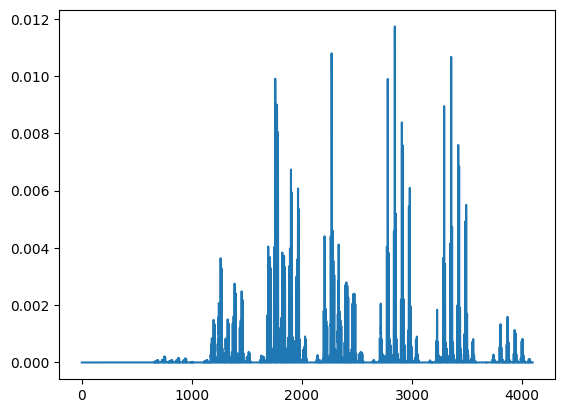

In [127]:
plt.plot(qdist_vec)

In [121]:
def get_discretized_operators(
    oom: ContinuousValuedOOM,
    intervals: list[tuple[float, float]],
) -> dict[DiscreteObservable, np.matrix]:
    """
    
    """
    obsops = {}
    for idx, interval in enumerate(intervals):
        il, ir = interval
        
        # Get operator over this interval
        wops = []
        for mf, op in zip(oom.membership_fns, oom.operators):
            weight = mf.cdf(ir) - mf.cdf(il)
            wop = weight * op
            wops.append(wop)
        op = sum(wops)
        
        obsops[DiscreteObservable(name=f"L{idx}_{interval}")] = op
    return obsops

In [129]:
qrinf = 3
qdintervals = [(-np.inf, -qrinf), *[(a, a+1) for a in range(-qrinf, qrinf)], (qrinf, np.inf)]
discretized_ops = get_discretized_operators(oom_cont, qdintervals)

## Both cases combined

In [173]:
def quantify_distribution(
    steps: int,
    state: np.matrix,
    operators: list[np.matrix],
    lin_func: np.matrix
) -> np.array:
    """
    
    """
    obsops = dict(zip(range(len(operators)), operators))
    pred_dists = {}
    
    for obscomb in itertools.product(obsops.keys(), repeat = steps):
        curr_state = state
        
        for obs in reversed(obscomb):
            curr_state = obsops[obs] * curr_state
        
        curr_p = lin_func * curr_state
        pred_dists[obscomb] = curr_p.item()
    
    # Order and return results
    pred_dists_ps = pd.Series(pred_dists)
    print('\n', pred_dists_ps, '\n\n', pred_dists_ps.sum(), sep='')
    return pred_dists_ps.values


0  0  0  0  0  0  0  0  0  0    0.000000
                           1    0.000000
                           2    0.000000
                        1  0    0.000000
                           1    0.000000
                                  ...   
2  2  2  2  2  2  2  2  1  1    0.000161
                           2    0.000026
                        2  0    0.000000
                           1    0.000085
                           2    0.000071
Length: 59049, dtype: float64

1.0000000000000002


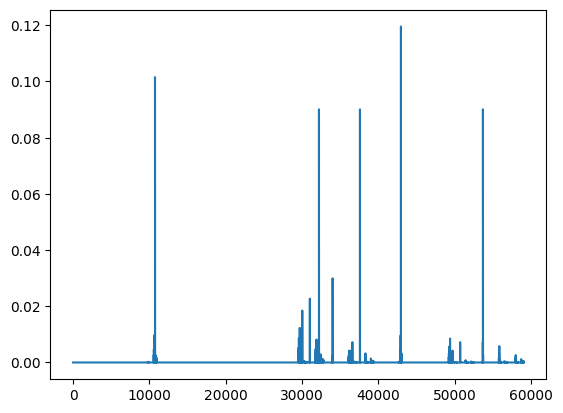

In [178]:
qd_vec_dist = quantify_distribution(
    10,
    oom_disc.start_state,
    oom_disc.operators,
    oom_disc.lin_func
)
plt.plot(qd_vec_dist)


0  0  0  0  0    2.426918e-22
            1    3.232355e-20
            2    5.505925e-19
            3    1.350194e-18
            4    6.283731e-19
                     ...     
7  7  7  7  3    3.336010e-08
            4    1.644533e-08
            5    2.344013e-08
            6    2.080483e-08
            7    3.107731e-09
Length: 32768, dtype: float64

1.0000000000000002


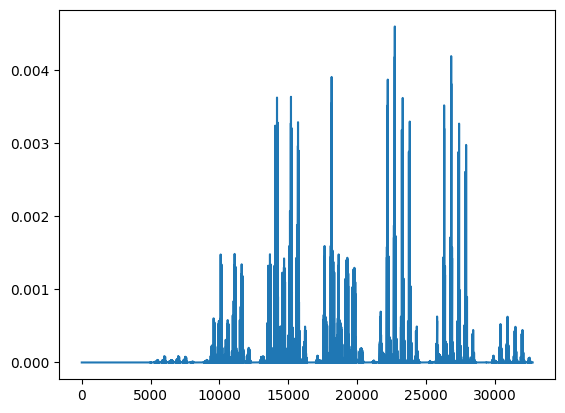

In [181]:
qrinf = 3
qdintervals = [(-np.inf, -qrinf), *[(a, a+1) for a in range(-qrinf, qrinf)], (qrinf, np.inf)]
discretized_ops = get_discretized_operators(oom_cont, qdintervals)

qd_vec_cont = quantify_distribution(
    5,
    oom_cont.start_state,
    list(discretized_ops.values()),
    oom_cont.lin_func
)
plt.plot(qd_vec_cont)

In [185]:
def kl_divergence(p, q):
    kldiv = np.sum(p * np.log(p / q))
    return kldiv

div = kl_divergence(qd_vec_cont, qd_vec_cont)
div

0.0